# Genre as a Predictor of Profit
## A Chi-Squared Analysis of Various Movie Genres as Potential Predictors of Profitability

### The Business Question
Does the genre of a movie have any association with the movie's profitability?

### The Datasets

### The Methods

#### Import Pandas and Warnings

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

#### Import Relevant Datasets

The relevant datasets for our analysis were the tn.movie_budgets.csv and tmdb.movies.csv files. 

In [2]:
budgets = pd.read_csv("../../../../data/tn.movie_budgets.csv")
tmdb = pd.read_csv("../../../../data/tmdb.movies.csv", index_col = 0)

#### Review the Contents of the Datasets and Areas that Require Cleaning

Before running our analysis, we needed to review the contents of the datasets, isolate relevant columns, and clean data as necessary. 

##### Budgets Dataframe

First, we looked at the first few rows of the dataset to get an idea of the column, potential datatypes, and areas which may require pre-processing/cleaning. 

In [3]:
budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


From this dataframe, we decided that we needed to retain the following columns:
- Movie (for joining with other dataframes)
- Production Budget and Worldwide Gross (for calculating profit)

Thus, we formed a subset of the dataset including only the relevant columns.

In [4]:
cols_to_keep = ['movie','production_budget','worldwide_gross']
budgets_relevant = budgets[cols_to_keep]
budgets_relevant.head()

,movie,production_budget,worldwide_gross
0,Avatar,"$425,000,000","$2,776,345,279"
1,Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$1,045,663,875"
2,Dark Phoenix,"$350,000,000","$149,762,350"
3,Avengers: Age of Ultron,"$330,600,000","$1,403,013,963"
4,Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$1,316,721,747"


We also noted that the production budget and worldwide gross columns were populated with strings (as evident by the symbolic characters used alongside the numeric characters, such as "$"). These values needed to be cleaned and cast as integers before they could be used to calculate profit. 

However, before doing any further cleaning we looked for null values and duplicates so that we could avoid making any unnecessary calculations

In [5]:
budgets_relevant.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   movie              5782 non-null   object
 1   production_budget  5782 non-null   object
 2   worldwide_gross    5782 non-null   object
dtypes: object(3)
memory usage: 135.6+ KB


Looking at the dataframe's information confirmed that the values within the production_budget and worldwide_gross columns were stored as strings and required cleaning. Furthermore, we could see that there were no obvious nulls in the dataframe. However, looking at the values stored within the worldwide_gross column brought to light some null-esque values. Namely, movies with a worldwide gross revenue of $0. 

In [6]:
budgets_relevant['worldwide_gross'].value_counts()

$0              367
$8,000,000        9
$2,000,000        6
$7,000,000        6
$15,000,000       4
               ... 
$4,584            1
$19,929,123       1
$22,921,898       1
$38,028,230       1
$182,291,969      1
Name: worldwide_gross, Length: 5356, dtype: int64

There were some zeroes in this column, presumably because there was no available data on its gross revenue. Rather than removing these observations, we decided to replace them with the median once the column had been properly cleaned. 

From here, we moved on to locating duplicate values. 

In [7]:
budgets_relevant.duplicated().value_counts()

False    5782
dtype: int64

There were no obvious duplicate rows. However, we realized that multiple movies could have the same title. This would pose an issue when we needed to join dataframes using movie titles as the mutual column. 

In [8]:
budgets_relevant['movie'].value_counts()

Home                        3
King Kong                   3
Halloween                   3
Night of the Living Dead    2
RoboCop                     2
                           ..
Her                         1
Paper Towns                 1
Crimson Tide                1
The Flintstones             1
Lincoln                     1
Name: movie, Length: 5698, dtype: int64

First, we looked into how many duplicate titles there were and if it was worth it to persue a method of merging the dataframes on two columns.

In [9]:
def get_title_counts(data, col):
    
    # set the value counts as a dataframe
    title_counts = pd.DataFrame(data[col].value_counts())
    
    # reset index so that we can easily access the titles
    title_counts = title_counts.reset_index()
    
    # take a subset of the title counts dataframe for all titles that appear more than once
    title_counts = title_counts.loc[ title_counts[col] > 1 ]
                                    
    # return this dataframe of title duplicates                                
    return title_counts

title_counts = get_title_counts(budgets_relevant, 'movie')
title_counts

,index,movie
0,Home,3
1,King Kong,3
2,Halloween,3
3,Night of the Living Dead,2
4,RoboCop,2
...,...,...
76,"20,000 Leagues Under the Sea",2
77,The Gambler,2
78,The Love Letter,2
79,Lolita,2


81 rows out of a 5,000+ row dataset didn't seem substantial enough to justify the attempted mutli-column merge given the time contraints of the project. So, we decided to simply drop the duplicates.

In [10]:
def remove_duplicate_titles(data, col):
    
    # get the dataframe for titles which appear more than once
    title_counts = get_title_counts(data,col)
    
    # create a dichotomous column for which there is a 1 if the movie is a duplicate title
    data['duplicate'] = data[col].map(lambda x: 1 if any([movie in x for movie in list(title_counts['index'])]) else 0)
    
    # take a subset of the dataframe of only non-duplicate titles
    data = data.loc[ data['duplicate'] == 0]
    
    # initialize a list of columns to maintain
    keepers = []
    
    # for each column in the dataframe
    for col in data.columns:
        # if it isn't the duplicate column
        if col != "duplicate":
            # add it to the list of columns to be maintained
            keepers.append(col)
    
    # keep only the columns intended
    data = data[keepers]
        
    return data

budgets_relevant = remove_duplicate_titles(budgets_relevant, 'movie')
budgets_relevant

<ipython-input-10-de8f23511d27>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['duplicate'] = data[col].map(lambda x: 1 if any([movie in x for movie in list(title_counts['index'])]) else 0)


,movie,production_budget,worldwide_gross
0,Avatar,"$425,000,000","$2,776,345,279"
1,Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$1,045,663,875"
2,Dark Phoenix,"$350,000,000","$149,762,350"
3,Avengers: Age of Ultron,"$330,600,000","$1,403,013,963"
4,Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$1,316,721,747"
...,...,...,...
5777,Red 11,"$7,000",$0
5778,Following,"$6,000","$240,495"
5779,Return to the Land of Wonders,"$5,000","$1,338"
5780,A Plague So Pleasant,"$1,400",$0


After checking for nulls and duplicates, we got started cleaning the budget and gross revenue columns so that we could eventually use them to calculate profit. 

In [11]:
def dollar_to_numeric(column):
    # removing $ and , from string
    column = column.str.replace(",","")
    column = column.str.replace("$","")

    # casting the values as integers
    column = pd.to_numeric(column)
    
    return column

budgets_relevant['worldwide_gross'] = dollar_to_numeric(budgets_relevant['worldwide_gross'])
budgets_relevant['production_budget'] = dollar_to_numeric(budgets_relevant['production_budget'])

budgets_relevant.head()

,movie,production_budget,worldwide_gross
0,Avatar,425000000,2776345279
1,Pirates of the Caribbean: On Stranger Tides,410600000,1045663875
2,Dark Phoenix,350000000,149762350
3,Avengers: Age of Ultron,330600000,1403013963
4,Star Wars Ep. VIII: The Last Jedi,317000000,1316721747


After successfully casting the data as integers, we looked at the descriptive statistics for any obvious issues.

In [12]:
budgets_relevant['production_budget'].describe()

count    5.459000e+03
mean     3.112546e+07
std      4.134343e+07
min      1.100000e+03
25%      5.000000e+06
50%      1.700000e+07
75%      4.000000e+07
max      4.250000e+08
Name: production_budget, dtype: float64

In [13]:
budgets_relevant['worldwide_gross'].describe()

count    5.459000e+03
mean     8.940551e+07
std      1.721636e+08
min      0.000000e+00
25%      3.808364e+06
50%      2.709288e+07
75%      9.655151e+07
max      2.776345e+09
Name: worldwide_gross, dtype: float64

There are some zeroes in the gross revenue dataset. Since this is unlikely, and more likely meant to be null, we looked to see how many rows this is the case for.

In [14]:
budgets_relevant['worldwide_gross'].value_counts()

0            355
8000000        7
7000000        6
2000000        6
4000000        4
            ... 
58545540       1
92618117       1
834953         1
190453132      1
310946         1
Name: worldwide_gross, Length: 5054, dtype: int64

Since this is a pretty substantial number of movies, but not a significant proportion of the dataset, we decided to impute these values with the median profit. The decision was made to use the median rather than the mean because of its resiliency against extreme outliers.

In [15]:
median_gross = budgets_relevant['worldwide_gross'].median()
budgets_relevant['worldwide_gross'] = budgets_relevant['worldwide_gross'].replace(0,median_gross)
budgets_relevant['worldwide_gross'].describe()

count    5.459000e+03
mean     9.116737e+07
std      1.713763e+08
min      2.600000e+01
25%      7.833752e+06
50%      2.709288e+07
75%      9.655151e+07
max      2.776345e+09
Name: worldwide_gross, dtype: float64

Now that we had two clean revenue and cost columns to work with, we used this information to create a new column in the dataframe for the calculated profit. 

In [16]:
# calculating total profit
budgets_relevant['total_profit'] =  budgets_relevant['worldwide_gross'] - budgets_relevant['production_budget']

budgets_relevant = budgets_relevant[['movie','total_profit']]

# confirmation
budgets_relevant['total_profit'].describe()

count    5.459000e+03
mean     6.004190e+07
std      1.431806e+08
min     -2.002376e+08
25%     -1.394899e+06
50%      1.415149e+07
75%      5.964086e+07
max      2.351345e+09
Name: total_profit, dtype: float64

Next, we decided to visualize the distribution of profit since this is our dependent variable.

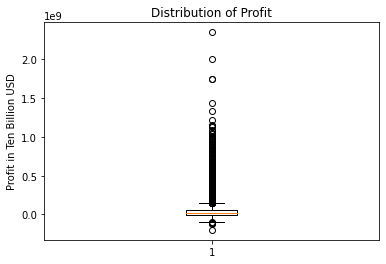

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots()
ax.boxplot(budgets_relevant['total_profit'])
ax.set_title("Distribution of Profit")
ax.set_ylabel("Profit in Ten Billion USD");

It was evident that there were some extremely profitable (and extremely unprofitable) movies that may influence the results of our analysis. Because of the presense of extremes, we decided to remove any movies with profits outside of the interquartile range.

Resource used: https://www.statology.org/remove-outliers-python/

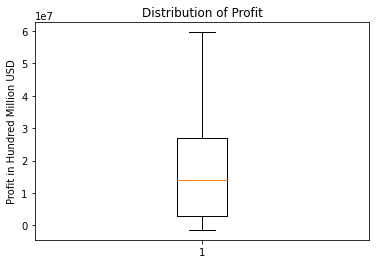

In [18]:
from scipy import stats

# find Q1, Q3, and interquartile range for each column
Q1 = budgets_relevant['total_profit'].quantile(q=.25)
Q3 = budgets_relevant['total_profit'].quantile(q=.75)
IQR = budgets_relevant['total_profit'].apply(stats.iqr)

budgets_relevant = budgets_relevant.loc[~((budgets_relevant['total_profit'] < (Q1-1.5*IQR)) | (budgets_relevant['total_profit'] > (Q3+1.5*IQR)))]

fig, ax = plt.subplots()
ax.boxplot(budgets_relevant['total_profit'])
ax.set_title("Distribution of Profit")
ax.set_ylabel("Profit in Hundred Million USD");


Knowing that we would eventually have to merge this dataframe with the TMDB dataframe, we also set the index to the column on which we wanted to merge (the movie title). 

In [19]:
budgets_relevant.set_index('movie', inplace = True)
budgets_relevant.head()

,total_profit
movie,
John Carter,7778100
Green Lantern,19535492
Jack the Giant Slayer,2687603
Hugo,47784
Valerian and the City of a Thousand Planets,35098356


With this dataframe cleaned, we moved on to the TMDB dataframe. 

##### TMDB Dataframe

Just like the first dataframe, we began by looking at the first few rows to get an idea of the columns, datatypes, and areas which may require preprocessing/cleaning. 

In [20]:
tmdb.head()

,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


From this dataframe, we noted that we only needed the following columns:
- Title (for merging)
- Genre_ids

We started with dropping the irrelevant columns.

In [21]:
cols_to_keep = ['title','genre_ids']
tmdb_relevant = tmdb[cols_to_keep]
tmdb_relevant.head()

,title,genre_ids
0,Harry Potter and the Deathly Hallows: Part 1,"[12, 14, 10751]"
1,How to Train Your Dragon,"[14, 12, 16, 10751]"
2,Iron Man 2,"[12, 28, 878]"
3,Toy Story,"[16, 35, 10751]"
4,Inception,"[28, 878, 12]"


We noted that the genre_ids column appeared to contain lists of multiple ids associated with specific genres. We needed to clean this column and replace these numbers with their associated genre. However, we decided to wait to replace these values until after the dummy columns were created because it would be easier to rename a small number of columns than replace multiple numbers in every cell with its associated genre. 

So for now, we moved on to locating null values and duplicates.

In [22]:
tmdb_relevant.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26517 entries, 0 to 26516
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      26517 non-null  object
 1   genre_ids  26517 non-null  object
dtypes: object(2)
memory usage: 621.5+ KB


There didn't appear to be any null values in the dataset.

In [23]:
tmdb_relevant.duplicated().value_counts()

False    25429
True      1088
dtype: int64

There were, however, some duplicate movies which we needed to drop.

In [24]:
tmdb_relevant = tmdb_relevant.drop_duplicates()

In [25]:
tmdb_relevant.duplicated().value_counts()

False    25429
dtype: int64

There were also more duplicate titles to remove. We handled these the same as we did in the budgets dataframe. 

In [26]:
tmdb_relevant['title'].value_counts()

Home             6
Lucky            5
Aftermath        5
The Gift         5
Truth            4
                ..
So Undercover    1
Pompeii          1
Short Term 12    1
Foxcatcher       1
Uwharrie         1
Name: title, Length: 24688, dtype: int64

In [27]:
tmdb_relevant = remove_duplicate_titles(tmdb_relevant,'title')
tmdb_relevant['title'].value_counts()

It's a Disaster                     1
The Final Straw                     1
The Olive Tree                      1
Dancer and the Dame                 1
Pelada                              1
                                   ..
My Super Psycho Sweet 16: Part 2    1
Texas Killing Fields                1
Knuckleball                         1
LelleBelle                          1
Uwharrie                            1
Name: title, Length: 17714, dtype: int64

After dropping these duplicate values, we set the movie titles as in the index in preparation for merging these two dataframes.

In [28]:
tmdb_relevant = tmdb_relevant.set_index('title')
tmdb_relevant

,genre_ids
title,
How to Train Your Dragon,"[14, 12, 16, 10751]"
Iron Man 2,"[12, 28, 878]"
Toy Story,"[16, 35, 10751]"
Inception,"[28, 878, 12]"
Percy Jackson & the Olympians: The Lightning Thief,"[12, 14, 10751]"
...,...
Laboratory Conditions,"[27, 18]"
_EXHIBIT_84xxx_,"[18, 53]"
The Last One,"[14, 28, 12]"


#### Merging the Dataframes

In [29]:
budgets_and_tmdb = budgets_relevant.join(tmdb_relevant, how='inner')
budgets_and_tmdb.info()

<class 'pandas.core.frame.DataFrame'>
Index: 656 entries, John Carter to Newlyweds
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   total_profit  656 non-null    int64 
 1   genre_ids     656 non-null    object
dtypes: int64(1), object(1)
memory usage: 15.4+ KB


After merging the dataframes, we were left with a much smaller dataframe than either of the parent datasets. This, however, was expected given there was no gaurantee that the datasets would overlap in their contents significantly nor was there a gaurantee that there would not be any spelling errors in the titles that would prevent a successful join for at least some rows. Given the timeframe of this project, we decided to proceed with the knowledge that 656 movies can still provide some useful insights.

#### Creating Dummy Columns for the Appropriate Genre

The genre_ids column is made up of strings. This means that we needed to remove any string characters and isolate each genre id before making dummy columns. We needed to accomplish the following:
1. Remove brackets and whitespace
2. Split by commas
3. Create a new dataframe with genres as columns and cells containing binary values, with 1 indicating a relevant genre for that movie. 

For this section, we utilized this resource to create our dummy columns: https://stackoverflow.com/questions/29034928/pandas-convert-a-column-of-list-to-dummies

In [30]:
def create_dummy_cols(data, col):
    
    # remove [, ], and whitespace
    data[col] = data[col].str.strip("]")
    data[col] = data[col].str.strip("[")
    data[col] = data[col].str.replace(" ", "")
    
    # split genre ids by commas
    genre_ids = data[col].str.split(",")
    
    # create the binary dummy columns
    bin_genre_df = pd.get_dummies(genre_ids.apply(pd.Series).stack()).sum(level=0)
    budgets_and_genre_dummys = data.join(bin_genre_df, how='inner')
    
    # rename columns for genres
    budgets_and_genre_dummys.rename(columns = {'28' : 'Action', 
                                           '12' : 'Adventure',
                                          '16' : 'Animation',
                                          '35' : 'Comedy',
                                          '80' : 'Crime',
                                          '99' : 'Documentary',
                                          '18' : 'Drama',
                                          '10751' : 'Family',
                                          '14' : 'Fantasy',
                                          '36' : 'History',
                                          '27' : 'Horror',
                                          '10402' : 'Music',
                                          '9648' : 'Mystery',
                                          '10749' : 'Romance',
                                          '878' : 'SciFi',
                                          '10770' : 'TV',
                                          '53' : 'Thriller',
                                          '10752' : 'War',
                                          '37' : 'Western'}, inplace = True)
    return budgets_and_genre_dummys

budgets_and_genre_dummys = create_dummy_cols(budgets_and_tmdb,'genre_ids')
budgets_and_genre_dummys

,total_profit,genre_ids,,Music,Romance,Family,War,TV,Adventure,Fantasy,...,Horror,Action,Comedy,History,Western,Thriller,Crime,SciFi,Mystery,Documentary
John Carter,7778100,"28,12,878",0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0
Green Lantern,19535492,"12,28,53,878",0,0,0,0,0,0,1,0,...,0,1,0,0,0,1,0,1,0,0
Jack the Giant Slayer,2687603,"28,12,10751,14",0,0,0,1,0,0,1,1,...,0,1,0,0,0,0,0,0,0,0
Hugo,47784,"12,18,10751",0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
Valerian and the City of a Thousand Planets,35098356,"12,878,28",0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Exeter,464792,"53,27",0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
Ten,27067880,"12,27,9648,53",0,0,0,0,0,0,1,0,...,1,0,0,0,0,1,0,0,1,0
Dry Spell,27070880,"35,10749",0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
All Superheroes Must Die,27072880,"878,53",0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0


Note: there is a dummy column seemingly associated with no genre. This appears to be the result of some titles which did not have any associated genre id. So, we dropped them from analysis. 

In [31]:
budgets_and_genre_dummys = budgets_and_genre_dummys.loc[ (budgets_and_genre_dummys[''] != 1) ] 

#### Turning Profit into a Categorical Variable

We decided to turn profit into a categorical variable denoting high vs. medium vs. low profit. The threshold values for these categories were decided as:

- High = 75th percentile and greater
- Medium = Greater than 25th percentile and lower than 75th percentile.
- Low = 25th percentile and lower

In [32]:
# define thresholds
iqr_Q1 = budgets_and_genre_dummys['total_profit'].quantile(q=.25)
iqr_Q3 = budgets_and_genre_dummys['total_profit'].quantile(q=.75)

# assign categories based on thresholds
budgets_and_genre_dummys.loc[ budgets_and_genre_dummys['total_profit'] >= iqr_Q3, 'relative_profit_cat'] = 'high'
budgets_and_genre_dummys.loc[ budgets_and_genre_dummys['total_profit'] <= iqr_Q1, 'relative_profit_cat'] = 'low'
budgets_and_genre_dummys.loc[ budgets_and_genre_dummys['relative_profit_cat'].isna() , 'relative_profit_cat'] = 'medium'

budgets_and_genre_dummys.head()

C:\Users\morpelletier\Anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\morpelletier\Anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\morpelletier\Anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

,total_profit,genre_ids,,Music,Romance,Family,War,TV,Adventure,Fantasy,...,Action,Comedy,History,Western,Thriller,Crime,SciFi,Mystery,Documentary,relative_profit_cat
John Carter,7778100,"28,12,878",0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,1,0,0,medium
Green Lantern,19535492,"12,28,53,878",0,0,0,0,0,0,1,0,...,1,0,0,0,1,0,1,0,0,medium
Jack the Giant Slayer,2687603,"28,12,10751,14",0,0,0,1,0,0,1,1,...,1,0,0,0,0,0,0,0,0,low
Hugo,47784,"12,18,10751",0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,low
Valerian and the City of a Thousand Planets,35098356,"12,878,28",0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,1,0,0,high


#### Building a Contingency Table

From here, we built a contingency table with genres as rows and relative profit category as columns. 

In [33]:
# initialize list of genres
genres = []

# for each column in the dataset
for column in budgets_and_genre_dummys.columns:
    # if it isn't a non-genre column
    ignored_cols = ['total_profit','title','relative_profit_cat','genre_ids','']  
    if column not in ignored_cols:
        # add it to the list of genres
        genres.append(column)
        
## Creating the contingency table

# create a dataframe with profit as columns and genres as rows
contingency_table = pd.DataFrame(columns = ['high', 'medium','low'], index = genres)

# replace the index (this is useful for using the numeric index to populate the dataframe in the next cell)
contingency_table.reset_index(inplace = True)

# fill the table with zeroes
contingency_table = contingency_table.fillna(0)
contingency_table.head()

,index,high,medium,low
0,Music,0,0,0
1,Romance,0,0,0
2,Family,0,0,0
3,War,0,0,0
4,TV,0,0,0


After creating the contingency table, we iterated through each row in the original dataframe to populate the contingency table based on genre and profit category. 

Resource: https://www.geeksforgeeks.org/how-to-set-cell-value-in-pandas-dataframe/

In [34]:
# for each row
for index, row in budgets_and_genre_dummys.iterrows():
    
    # for each column in that row that is a genre
    for col in budgets_and_genre_dummys.columns:
        
        if col not in ignored_cols:
    
            # if the cell value is 1
            if row[col] == 1 :
                
                # find the index associated with that genre in the contingency table
                genre_idx = contingency_table[contingency_table['index'] == col].index.values
                
                # look at the profit category column and save that value as well
                profit_cat = row['relative_profit_cat']
    
                # find the cell associated with that row index and profit column in the contingency table and add 1 
                contingency_table.loc[genre_idx, profit_cat] += 1   
                
contingency_table

,index,high,medium,low
0,Music,1,6,5
1,Romance,27,47,28
2,Family,17,23,6
3,War,3,5,2
4,TV,0,3,1
5,Adventure,22,32,10
6,Fantasy,12,15,12
7,Animation,10,14,2
8,Drama,71,163,99
9,Horror,24,50,18


We noted that there were some genres where there weren't many movies. To avoid drawing conclusions based on small sample sizes, we decided to filter out rows in the contingency table with row totals less than 50. 

In [35]:
#contingency_table = contingency_table.loc[(contingency_table['high'] >= 10) & (contingency_table['medium'] >= 10) & (contingency_table['low'] >= 10)]
contingency_table = contingency_table.loc[contingency_table['high'] + contingency_table['medium'] + contingency_table['low'] >= 50]

In [36]:
contingency_table = contingency_table.set_index('index')
contingency_table

,high,medium,low
index,,,
Romance,27,47,28
Adventure,22,32,10
Drama,71,163,99
Horror,24,50,18
Action,36,69,14
Comedy,55,103,47
Thriller,45,101,41
Crime,30,38,19
SciFi,15,27,9


#### Chi-Square Test

With the contingency table populated and filtered for decent sample size, we were ready to conduct the chi-squared test.

Resource: https://www.geeksforgeeks.org/python-pearsons-chi-square-test/

In [37]:
from scipy.stats import chi2_contingency

# H_0 : Genre and Profit Level are not associated
# H_1: Genre and Profit Level are associated

stat, p, dof, expected = chi2_contingency(contingency_table)
  
# interpret p-value
alpha = 0.05
print("p value is " + str(p))
if p <= alpha:
    print('Reject H_0')
else:
    print('Retain H_0')

p value is 0.04456193254973362
Reject H_0


In [38]:
# Getting relevant values to calculate Cramer's V
import numpy as np

# Sample size
n = contingency_table['low'].sum() + contingency_table['medium'].sum() + contingency_table['high'].sum()

# Number of rows
r = len(contingency_table)

# Number of columns
c = 3

cramer = np.sqrt((stat/n) / min(c-1,r-1))

print("Cramer's V: {}".format(round(cramer,2)))

Cramer's V: 0.11


What this told us was that there was a significant association between these genres and relative profit categories, but that it was very weak. To dive deeper into the specifics, we dichotomized our profit variable. 

We began with collapsing our medium and low profit categories into one category. This would allow us to see if there is a significant association between genres and higher profits. 

In [39]:
# Creating a copy of the contingency table
high_v_not_contingency = contingency_table.copy()

In [40]:
# Creating a new column to collapse the non-high profit categories into. 
high_v_not_contingency['not_high'] = high_v_not_contingency['medium'] + high_v_not_contingency['low']

In [41]:
# Isolating relevant columns
high_v_not_contingency = high_v_not_contingency[['high','not_high']]
high_v_not_contingency

,high,not_high
index,,
Romance,27,75
Adventure,22,42
Drama,71,262
Horror,24,68
Action,36,83
Comedy,55,150
Thriller,45,142
Crime,30,57
SciFi,15,36


From here, we conducted a new chi-square test to determine the presence of a significant association. 

In [42]:
stat, p, dof, expected = chi2_contingency(high_v_not_contingency)
  
# interpret p-value
alpha = 0.05
print("p value is " + str(p))
if p <= alpha:
    print('Reject H_0')
else:
    print('Retain H_0')

p value is 0.20704760836207542
Retain H_0


However, there was no significant association between genre and these profit categories. So, there doesn't appear to be a genre which generates significantly higher profit. However, there may be a genre that predicts significantly lower profit. 

To investigate this, we returned to our original contingency table and collapsed the 'high' and 'medium' columns into one column for non-low profit.

In [43]:
# Creating a copy of the original contingency table
low_v_not_contingency = contingency_table.copy()

In [44]:
# Collapsing high and medium profit categories into one column
low_v_not_contingency['not_low'] = low_v_not_contingency['high'] + low_v_not_contingency['medium']

In [45]:
# Isolating relevant columns
low_v_not_contingency = low_v_not_contingency[['low','not_low']]
low_v_not_contingency

,low,not_low
index,,
Romance,28,74
Adventure,10,54
Drama,99,234
Horror,18,74
Action,14,105
Comedy,47,158
Thriller,41,146
Crime,19,68
SciFi,9,42


We then conducted yet another Chi-Square test for significance. 

In [46]:
stat, p, dof, expected = chi2_contingency(low_v_not_contingency)
  
# interpret p-value
alpha = 0.05
print("p value is " + str(p))
if p <= alpha:
    print('Reject H_0')
else:
    print('Retain H_0')

p value is 0.009709037889535192
Reject H_0


The results were significant, meaning that there is a statistically significant association between genre and low profits. However, we do not know the strength of this association. To conceptualize the strength of their relationship, we calculated the Cramer's V value.

Resources used: 
- Cramer's V Methodology in Python: https://www.statology.org/cramers-v-in-python/#:~:text=Cramer%E2%80%99s%20V%20is%20a%20measure%20of%20the%20strength,Cramer%E2%80%99s%20V%20for%20a%20contingency%20table%20in%20Python.
- Interpreting Cramer's V value: https://www.ibm.com/docs/en/cognos-analytics/11.1.0?topic=terms-cramrs-v
- Interpreting magnitude of Cramer's V: https://www.datascienceblog.net/post/statistical_test/effect_size/#:~:text=To%20interpret%20Cramer%E2%80%99s%20V%2C%20the%20following%20approach%20is,medium%20association%203%20V%20%3E%200.5%3A%20strong%20association

In [47]:
# Getting relevant values to calculate Cramer's V

# Sample size
n = low_v_not_contingency['low'].sum() + low_v_not_contingency['not_low'].sum()

# Number of rows
r = len(low_v_not_contingency)

# Number of columns
c = 2

import numpy as np

cramer = np.sqrt((stat/n) / min(c-1,r-1))

print("Cramer's V: {}".format(round(cramer,2)))

Cramer's V: 0.13


The Cramer's V value ranges from 0 to 1. A result this small is indicative of a weak relationship between genre and low profit. 
So while our results remain statistically significant, the strength of their association is weak. 

Still we wondered, for which genres do we have greater proportions of profits above the 25th percentile?

To conceptualize this, we looked at the proportion of low profit vs. non-low profit within each genre. Then, we sorted our results such that the genre with the highest proportion of low profit movies appears highest on the dataframe. 

In [48]:
low_v_not_contingency['perc_low'] = round((low_v_not_contingency['low'] / (low_v_not_contingency['low'] + low_v_not_contingency['not_low']))*100,2)
low_v_not_contingency['perc_not_low'] = round((low_v_not_contingency['not_low'] / (low_v_not_contingency['low'] + low_v_not_contingency['not_low']))*100,2)
low_v_not_contingency = low_v_not_contingency[['perc_not_low','perc_low']]
low_v_not_contingency = low_v_not_contingency.sort_values(by = 'perc_low', ascending = False)
low_v_not_contingency

,perc_not_low,perc_low
index,,
Drama,70.27,29.73
Romance,72.55,27.45
Mystery,75.86,24.14
Comedy,77.07,22.93
Thriller,78.07,21.93
Crime,78.16,21.84
Horror,80.43,19.57
SciFi,82.35,17.65
Adventure,84.38,15.62


As a result, we can see that dramas have the greatest proportion of low-profit movies among our ten genre categories. This may be counterintuitive when paired with the knowledge that dramas were the genre that appeared most frequently within the dataframe.

However, it still remains that there is no strong relationship between genre and profit. So, our business recommendation is as follows: 

## Business Recommendation

Our original business question asked: Does the genre of a movie have any association with the movie's profitability? From our analysis, we can now answer that the relationship between genre and profit is extremely weak. Because of this, our recommendation is to avoid seeking profit by restricting film production to a specific genre, as there is no evidence of a strong association between these two variables. Instead, we suggest additional research into potential confounding factors that  may target the aforementioned higher median profits in animation, adventure, science fiction, action, and fantasy movies. 

## Limitations

Our results do not come without limitations. For example, while we did our best to ensure that the two tables were joined accurately, there exists the possibility that there could be a movie on one dataset with a title shared by an entirely different movie on the other dataset. Future research using data from one resource rather than multiple may help circumvent this issue and provide additional insight. 

There was also the limitation of a relatively small sample size given the original sizes of our raw data. Unfortunately, a lot of movies had to be removed from the dataset during cleaning in order to optimize the accuracy of our output. However, similar studies with larger sample sizes would be beneficial in confirming the results of this analysis. 

Finally, we imputed some values in our dataset to preserve a decent sample size. However, this does introduce potential inaccuracy in our results. Future research with more valid data could provide additional insight.

## Relevant Visualizations of the 10 Final Genres

### Boxplot of Profit Distributions by Genre for Final Dataset

The boxplots below visualize the distributions of profits for the ten genres that were included in the final analysis.

Resources used included:
- https://stackoverflow.com/questions/70927004/plotting-several-boxplots-from-different-dataframes-in-one-graph
- https://www.geeksforgeeks.org/how-to-set-a-seaborn-chart-figure-size/#:~:text=To%20adjust%20the%20figure%20size%20of%20the%20seaborn,returns%20the%20figure%20and%20the%20array%20of%20axes.

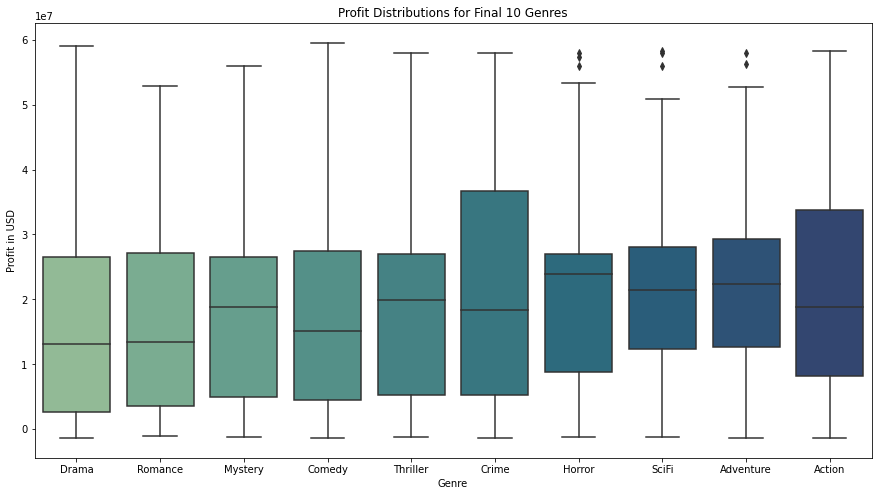

In [49]:
# Creating separate dataframes for each genre
romances = budgets_and_genre_dummys.loc[(budgets_and_genre_dummys['Romance'] == 1)] 
adventures = budgets_and_genre_dummys.loc[(budgets_and_genre_dummys['Adventure'] == 1)]
dramas = budgets_and_genre_dummys.loc[(budgets_and_genre_dummys['Drama'] == 1)]
horrors = budgets_and_genre_dummys.loc[(budgets_and_genre_dummys['Horror'] == 1)]
actions = budgets_and_genre_dummys.loc[(budgets_and_genre_dummys['Action'] == 1)]
comedies = budgets_and_genre_dummys.loc[(budgets_and_genre_dummys['Comedy'] == 1)]
thrillers = budgets_and_genre_dummys.loc[(budgets_and_genre_dummys['Thriller'] == 1)] 
crimes = budgets_and_genre_dummys.loc[(budgets_and_genre_dummys['Crime'] == 1)]
scifis = budgets_and_genre_dummys.loc[(budgets_and_genre_dummys['SciFi'] == 1)] 
mysteries = budgets_and_genre_dummys.loc[(budgets_and_genre_dummys['Mystery'] == 1)]


# Creating one dataframe for each genre and their profits
combined_dfs = pd.DataFrame({'Romance': romances['total_profit'],
                             'Adventure': adventures['total_profit'],
                             'Drama': dramas['total_profit'],
                             'Horror': horrors['total_profit'],
                             'Action': actions['total_profit'],
                             'Comedy': comedies['total_profit'],
                             'Thriller': thrillers['total_profit'],
                             'Crime': crimes['total_profit'],
                             'SciFi': scifis['total_profit'],
                             'Mystery': mysteries['total_profit']})

# Creating a list of genres in order of greatest to lowest proportion of low profit movies 
# Creating this list so that visualizations can match the order of the most recent contingency table
genre_order = []
for idx, row in low_v_not_contingency.iterrows():
    genre_order.append(idx)
genre_order

### Visualizing Profit distributions

import seaborn as sns

fig, ax = plt.subplots(figsize = (15,8))
sns.boxplot(data=combined_dfs, palette='crest', order = genre_order)
ax.set_title("Profit Distributions for Final 10 Genres")
ax.set_xlabel("Genre")
ax.set_ylabel("Profit in USD");
plt.show()

This visualization helps demonstrate that the overall distributions for each genre are relatively similar, which is consistent with our interpretation of the Cramer's V value. 

### Bar Chart of Genre Frequency for Final Dataset

The bar chart below visualizes the number of movies representing each genre in the final dataset.

Resource: https://datavizpyr.com/sort-bars-in-barplot-using-seaborn-in-python/#:~:text=Sort%20Bars%20in%20Barplot%20in%20Ascending%20Order%20in,variable%20in%20the%20order%20we%20want%20to%20plot.

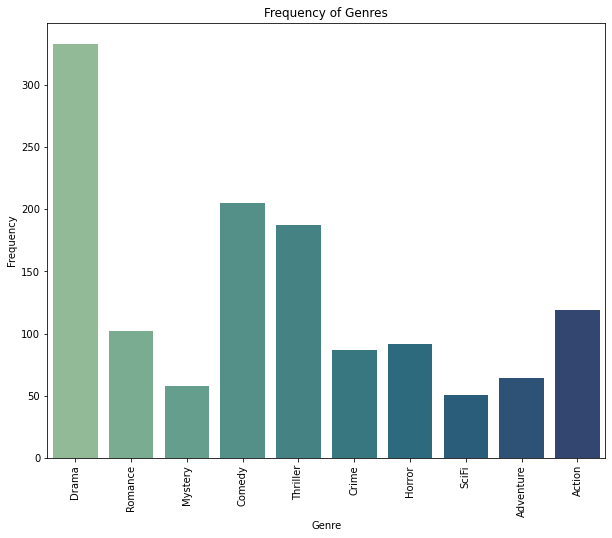

In [50]:
# Take the subset of the dataframe for only the genres included in the final dataset. 
final_genres_df = budgets_and_genre_dummys.loc [ (budgets_and_genre_dummys['Romance'] == 1) 
                                                | (budgets_and_genre_dummys['Adventure'] == 1) 
                                                | (budgets_and_genre_dummys['Drama'] == 1) 
                                                | (budgets_and_genre_dummys['Horror'] == 1) 
                                                | (budgets_and_genre_dummys['Action'] == 1) 
                                                | (budgets_and_genre_dummys['Comedy'] == 1) 
                                                | (budgets_and_genre_dummys['Thriller'] == 1) 
                                                | (budgets_and_genre_dummys['Crime'] == 1) 
                                                | (budgets_and_genre_dummys['SciFi'] == 1) 
                                                | (budgets_and_genre_dummys['Mystery'] == 1)  ]


# Create a frequency dictionary for the genres 
# (must be done manually rather than my value_counts since there are multiple genres in each row)

def freq_dictionary(dataframe):
    genre_sums = {}
    
    for col in dataframe.columns:
    
        ignored_cols = ["title", "genre_ids","total_profit",'relative_profit_cat',""]
        
        # for each genre column
        if col not in ignored_cols:
            
            # create a key in the dictionary for that genre
            # make the value equal to the total number of movies with a 1 in that column (equal to sum)
            genre_sums[col] = dataframe[col].sum()
        
    return genre_sums

genre_sums = freq_dictionary(final_genres_df)


# plot the frequency dictionary in order at which the genres appear in the final contingency table
fig, ax = plt.subplots(figsize=(10,8))
sns.barplot(x = list(genre_sums.keys()), y = list(genre_sums.values()), order = genre_order, palette = 'crest')
plt.xticks(rotation = 90)
ax.set_title("Frequency of Genres")
ax.set_xlabel("Genre")
ax.set_ylabel("Frequency");

While there doesn't appear to be a particular trend in this order, it is interesting that dramas, which have the highest proportion of low profit movies, are also the most represented.

### Stacked Bar Charts

The following barchart visualizes the proportional differences in profit categories for the genres in the final contingency table.

Resource: https://www.datasciencelearner.com/stacked-bar-graph-in-python-step/#:~:text=We%20can%20draw%20a%20stacked%20bar%20graphs%20in,seaborn%20library%20as%20well%20to%20achieve%20the%20same.

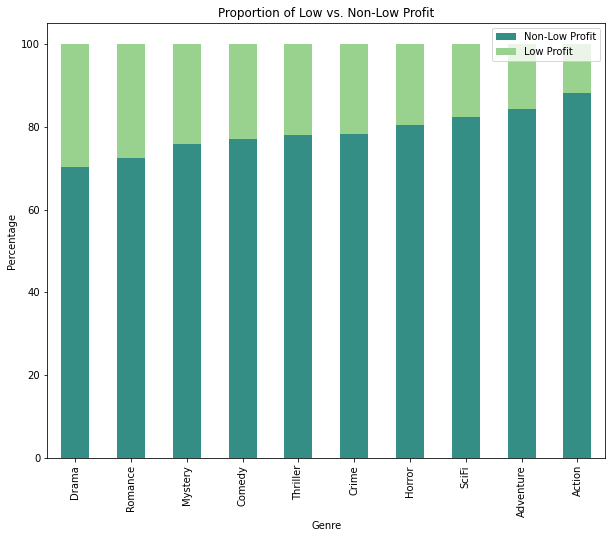

In [51]:
ax = low_v_not_contingency.plot(kind = 'bar', stacked = True, 
                           title = "Proportion of Low vs. Non-Low Profit", 
                           figsize = (10,8),
                           color = ['#358e85', '#99d18f'])
ax.set_xlabel("Genre")
ax.set_ylabel("Percentage")
ax.legend(['Non-Low Profit','Low Profit']);

The following bar charts visualize the proportion of high, medium, and low profit movies for all genres included in the final analysis. The only difference between the two is the order in which the genres are sorted. The former sorts from largest to smallest proportion of high profit movies, the latter sorts from largest to smallest proportion of low profit movies. 

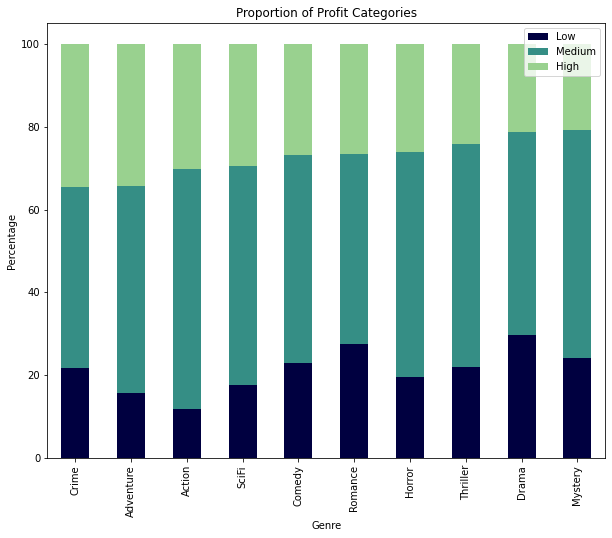

In [52]:
# Create percetange columns
contingency_table['perc_low'] = round( (contingency_table['low'] / 
                                        (contingency_table['low'] + 
                                         contingency_table['medium'] + 
                                         contingency_table['high']))*100,2)
contingency_table['perc_medium'] = round( (contingency_table['medium'] / 
                                        (contingency_table['low'] + 
                                         contingency_table['medium'] + 
                                         contingency_table['high']))*100,2)
contingency_table['perc_high'] = round( (contingency_table['high'] / 
                                        (contingency_table['low'] + 
                                         contingency_table['medium'] + 
                                         contingency_table['high']))*100,2)

# Create new dataframe which only contains the percentage columns
# sort by greatest proportion of hight profit movies to lowest proportion
contingency_table_prop = contingency_table[['perc_low','perc_medium','perc_high']]
contingency_table_prop = contingency_table_prop.sort_values(by = 'perc_high', ascending = False)

# plot the percentage dataframe
ax = contingency_table_prop.plot(kind = 'bar', stacked = True, 
                           title = "Proportion of Profit Categories", 
                           figsize = (10,8),
                           color = ['#000040', '#358e85', '#99d18f'])
ax.set_xlabel("Genre")
ax.set_ylabel("Percentage")
ax.legend(['Low','Medium', 'High']);

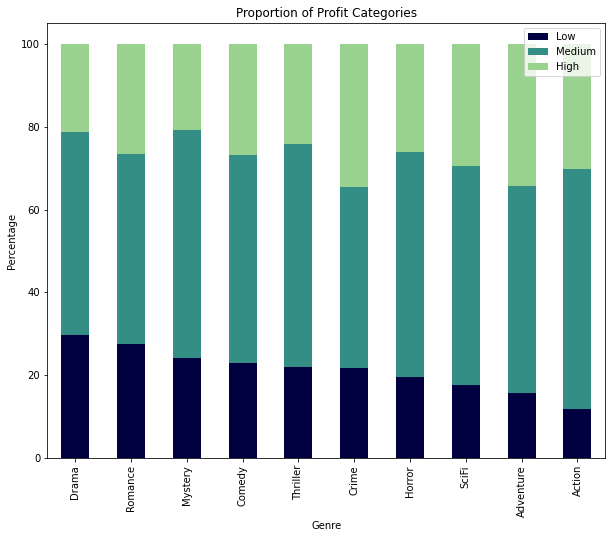

In [53]:
# re-sort proportion table from highest percentage of low profit movies to lowest proportion
contingency_table_prop = contingency_table_prop.sort_values(by = 'perc_low', ascending = False)

# plot the newly sorted dataframe
ax = contingency_table_prop.plot(kind = 'bar', stacked = True, 
                           title = "Proportion of Profit Categories", 
                           figsize = (10,8),
                           color = ['#000040', '#358e85', '#99d18f'])
ax.set_xlabel("Genre")
ax.set_ylabel("Percentage")
ax.legend(['Low','Medium', 'High']);